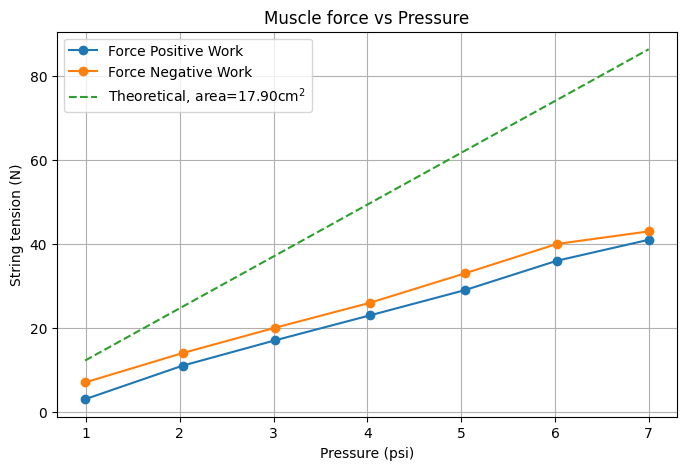

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV data
df = pd.read_csv("pressuredata.csv")

pressure = df['psi']*6894.76

# Plot force_poswork and force_negwork vs psi
plt.figure(figsize=(8,5))
plt.plot(df['psi'], df['force_poswork'], marker='o', label='Force Positive Work')
plt.plot(df['psi'], df['force_negwork'], marker='o', label='Force Negative Work')

tube_cirmcumference = 0.075*2
radius = tube_cirmcumference/(2*np.pi)
area = np.pi * radius**2

forces = area*pressure
plt.plot(df['psi'], forces, '--', label=fr"Theoretical, area={area*100**2:.2f}cm$^2$")


plt.xlabel('Pressure (psi)')
plt.ylabel('String tension (N)')
plt.title('Muscle force vs Pressure')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
radius

0.0238732414637843